In [1]:
from dataset.semi import SemiDataset
from model.semseg.deeplabv2 import DeepLabV2
from model.semseg.deeplabv3plus import DeepLabV3Plus
from model.semseg.pspnet import PSPNet
from utils import count_params, meanIOU, color_map, Accuracy, DiceCoefficient

from utilsf.loss_file import save_loss

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse
from copy import deepcopy
import numpy as np
import os
from PIL import Image
import torch
from torch.nn import CrossEntropyLoss, DataParallel
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
criterion = CrossEntropyLoss(ignore_index=255)
data_root = '/home/u5169119/dataset/0_data_dataset_voc_950_kidney'
dataset = 'kidney'
pretrained_weights_path = 'outdir/models/kidney/0114/resnet18/ST++/model_weight_re-training-2st.pth'

valset = SemiDataset(dataset, data_root, 'val', None)
valloader = DataLoader(valset, batch_size=8, shuffle=False, pin_memory=True, num_workers=4, drop_last=False)

In [4]:
model = DeepLabV3Plus('resnet18', 21)
state_dict = torch.load(pretrained_weights_path)
model.load_state_dict(state_dict)
model = DataParallel(model).cuda()

In [5]:
model.eval()
tbar = tqdm(valloader)

model.eval()
total_v_loss = 0.0
metric_miou = meanIOU(num_classes=21)
metric_dice = DiceCoefficient(num_classes=21)
metric_acc = Accuracy()

with torch.no_grad():
    for img, mask, _ in tbar:
        img = img.cuda()
        pred = model(img)
        mask = mask.cuda()  # 確保 mask 也在 GPU 上

        loss = criterion(pred, mask)

        total_v_loss += loss.item() 

        pred = torch.argmax(pred, dim=1)
           
        metric_miou.add_batch(pred.cpu().numpy(), mask.cpu().numpy())
        metric_dice.add_batch(pred.cpu().numpy(), mask.cpu().numpy())
        metric_acc.add_batch(pred.cpu().numpy(), mask.cpu().numpy())
        mIOU = metric_miou.evaluate()[-1]
        tbar.set_description('mIOU: %.2f' % (mIOU * 100.0))


  0%|          | 0/12 [00:00<?, ?it/s]/home/u5169119/ST-PlusPlus/utils.py:62: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(self.hist) / (self.hist.sum(axis=1) + self.hist.sum(axis=0) - np.diag(self.hist))
mIOU: 74.89: 100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


In [6]:
for img, mask, _ in valloader:
    img = img.cuda()
    pred = model(img)
    pred = torch.argmax(pred, dim=1)
    break

print('img shape: ', img.shape)
print('mask shape: ', mask.shape)
print('pred shape: ', pred.shape)

img shape:  torch.Size([8, 3, 768, 1024])
mask shape:  torch.Size([8, 768, 1024])
pred shape:  torch.Size([8, 768, 1024])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


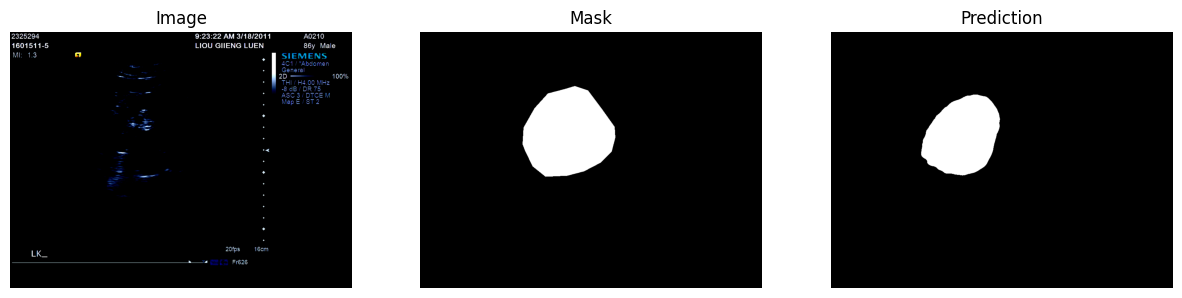

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


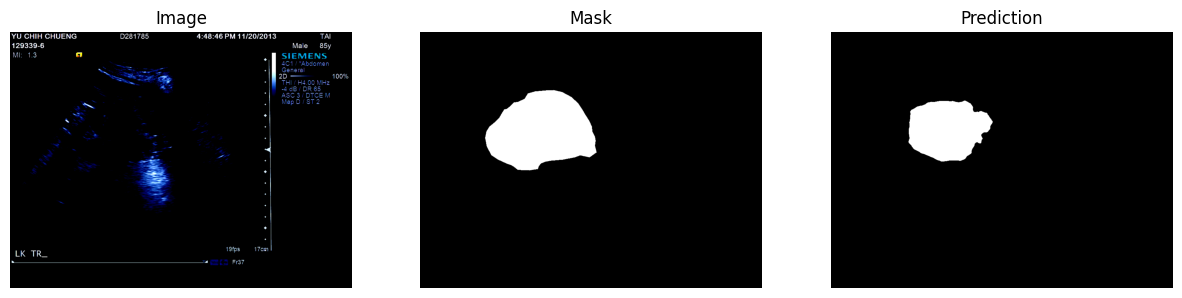

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


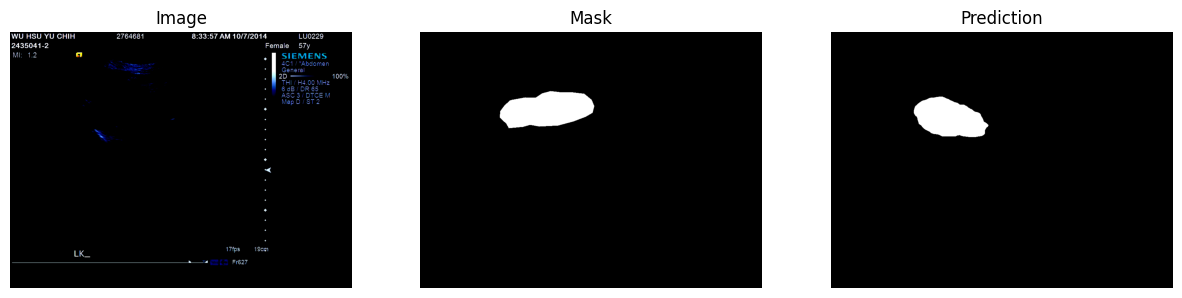

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


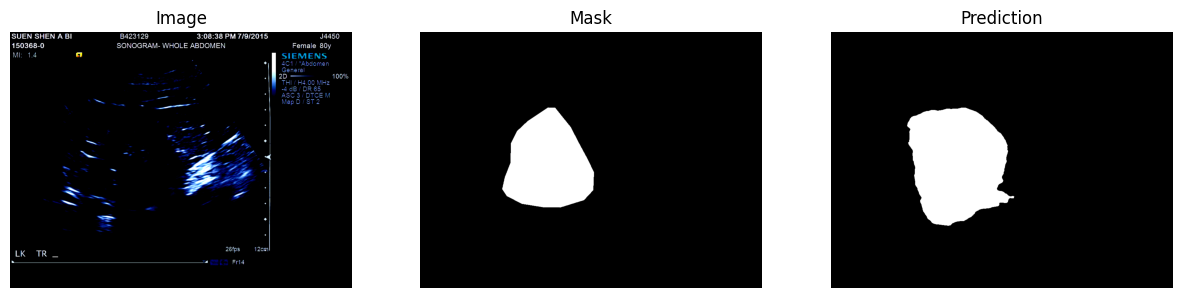

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


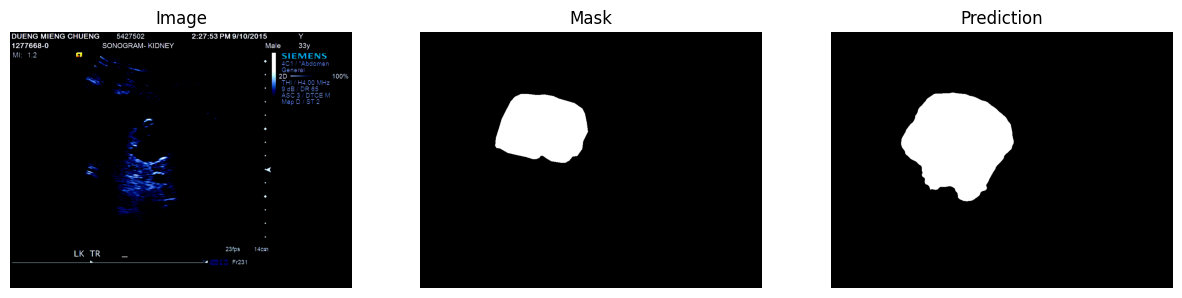

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


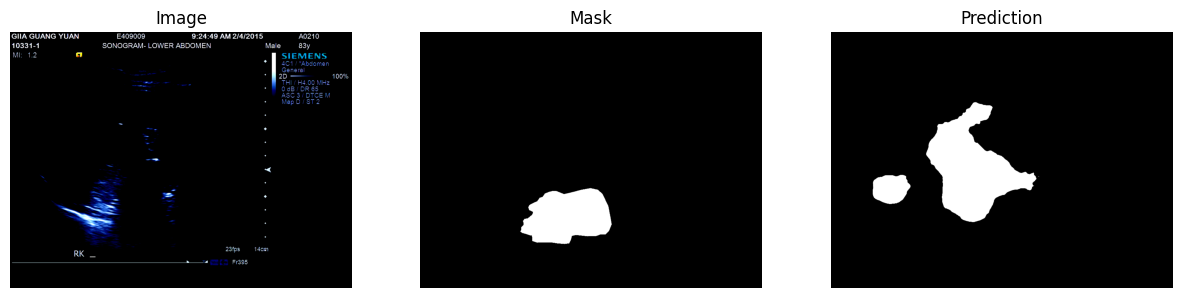

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


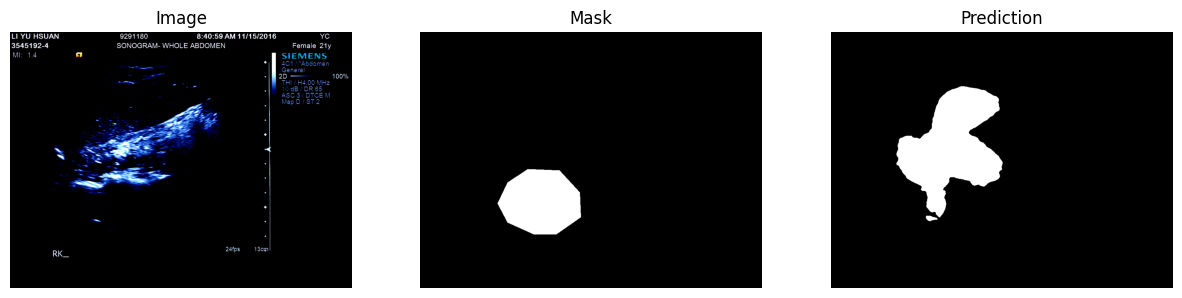

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


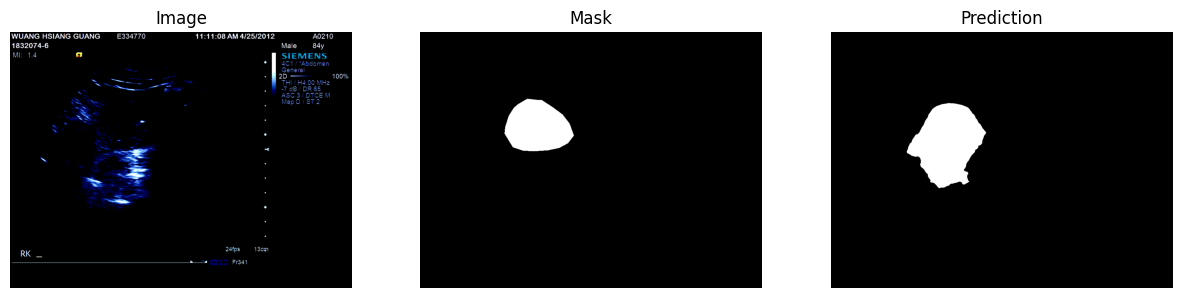

In [7]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(8):
    # 取出單張圖像
    img_np = img[i].cpu().numpy().transpose(1, 2, 0)  # 轉換為 HWC 格式
    mask_np = mask[i].cpu().numpy()
    pred_np = pred[i].cpu().numpy()

    # 繪製圖像、mask 和 pred
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img_np)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask_np, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    axes[2].imshow(pred_np, cmap='gray')
    axes[2].set_title('Prediction')
    axes[2].axis('off')

    plt.show()

In [8]:
avg_test_loss = total_v_loss / len(valloader)
avg_train_miou = metric_miou.evaluate()[-1]
avg_train_dice = metric_dice.evaluate()
avg_train_acc = metric_acc.evaluate()


print("Test Loss: %.4f, mIOU: %.4f, Accuracy: %.4f, Dice Coefficient: %.4f" % 
      (avg_test_loss, avg_train_miou, avg_train_acc, avg_train_dice ))

Test Loss: 0.1026, mIOU: 0.7489, Accuracy: 0.9549, Dice Coefficient: 0.6316


/home/u5169119/ST-PlusPlus/utils.py:62: RuntimeWarning: invalid value encountered in divide
  iu = np.diag(self.hist) / (self.hist.sum(axis=1) + self.hist.sum(axis=0) - np.diag(self.hist))
